# Initialization

In [1]:
import sys
sys.path.append("../src")
import os
import numpy as np
import pickle
import json
import pandas as pd
from grabbit import Layout
from mne import read_epochs, grand_average, write_evokeds, read_evokeds
from mne import pick_types, combine_evoked, set_log_level, grand_average
from mne.time_frequency import tfr_morlet, read_tfrs, write_tfrs
from mne.viz import plot_compare_evokeds
from mne.channels import find_ch_connectivity
from utils import CH_NAMES, select_subjects, drop_bad_trials
from eeg_sensor_analysis import baseline_normalize, power_heatmap, add_events
from surface_laplacian import surface_laplacian
from mne.stats import spatio_temporal_cluster_1samp_test
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed
import statsmodels.api as sm

sns.set(style='whitegrid', font_scale=2)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
set_log_level('critical')

# load subjects to process
layout = Layout('../data', '../data/grabbit_config.json')
subjects = select_subjects(layout, 'eeg', exclude='eeg')

# Analysis Parameters 
conditions = ['incongruent', 'congruent']
epoch_types = ['stimulus', 'response']
epoch_times = [(-.5, 1.75), (-1, 1)]
baseline = (-.5, -.1)
# match Cohen, Donner 2013 
frequencies = np.logspace(np.log10(2), np.log10(60), num=30) 
n_cycles = np.logspace(np.log10(3), np.log10(10), num=30) 

# load behavior
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv', 
                       na_values='n/a', sep='\t') 
behavior = behavior[behavior.modality == 'eeg']

# make eeg_sensor derivative directory structure
pipeline_root = '../data/derivatives/eeg_sensor'
if not os.path.exists(pipeline_root):
    os.makedirs(pipeline_root)
if not os.path.exists('%s/stats' % pipeline_root):
    os.makedirs('%s/stats' % pipeline_root)
for subject in subjects + ['group']:
    if not os.path.exists('%s/%s' % (pipeline_root, subject)):
        os.makedirs('%s/%s' % (pipeline_root, subject))
    if not os.path.exists('%s/%s/evoked' % (pipeline_root, subject)):
        os.makedirs('%s/%s/evoked' % (pipeline_root, subject))
    if not os.path.exists('%s/%s/tfr' % (pipeline_root, subject)):
        os.makedirs('%s/%s/tfr' % (pipeline_root, subject))
    if not os.path.exists('%s/%s/lap' % (pipeline_root, subject)):
        os.makedirs('%s/%s/lap' % (pipeline_root, subject))

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Surface Laplacian

In [2]:
coord_file = '../data/eeg_spherical_coordinates.txt'
coords = pd.read_csv(coord_file, names=['num', 'ch', 'x', 'y', 'z'], sep=',')
x, y, z = np.array(coords.x), np.array(coords.y), np.array(coords.z)

epo_root = '../data/derivatives/eeg_preprocessing'
for epo_type, epo_times in zip(epoch_types, epoch_times):
    print(epo_type)
    
    group = {'incongruent': [], 'congruent': []}
    
    for subject in subjects:
        if subject == 'group':
            continue
        print(subject)
            
        # load subject epochs & behavior
        f = '%s/%s/epochs/%s_%s_cleaned-epo.fif' % (epo_root, subject,
                                                    subject, epo_type)
        epochs = read_epochs(f, verbose=False)
        sub_behavior = behavior[behavior.participant_id == subject]
        
        lap_epochs = surface_laplacian(epochs, x, y, z, 'epochs')
        
        f = '%s/%s/lap/%s_%s_lap-epo.fif' % (pipeline_root, subject, subject,
                                             epo_type)
        lap_epochs.save(f)

print('Done!')

stimulus
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
response
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
su

# ERPs

## Make Evoked Data

In [3]:
for epo_class in ['base', 'laplacian']:
    print(epo_class)
    
    if epo_class == 'base':
        epo_root = '../data/derivatives/eeg_preprocessing/%s/epochs/%s_%s_cleaned-epo.fif'
    else:
        epo_root = '../data/derivatives/eeg_sensor/%s/lap/%s_%s_lap-epo.fif'
        
    for epo_type, epo_times in zip(epoch_types, epoch_times):
        print(epo_type)

        group = {'incongruent': [], 'congruent': []}

        for subject in subjects:
            if subject == 'group':
                continue

            print(subject)

            # load subject epochs & behavior
            epo_file = epo_root % (subject, subject, epo_type)
            epochs = read_epochs(epo_file, verbose=False)
            sub_behavior = behavior[behavior.participant_id == subject]

            # crop filter period
            epochs.crop(epo_times[0], epo_times[1])

            # drop bad trials from epochs and behavior
            sub_behavior, epochs = drop_bad_trials(subject, sub_behavior,
                                                   epochs, layout, epo_type)

            # add event labels
            epochs = add_events(epochs, sub_behavior)

            # interpolate bads
            bads = epochs.info['bads']
            epochs.interpolate_bads(reset_bads=True)

            # extract evoked and standard error
            evos = [epochs[c].average() for c in conditions]
            evos_std = [epochs[c].standard_error() for c in conditions]

            # save evoked and standard error
            f = '%s/%s/evoked/%s_%s_%s-ave.fif' % (pipeline_root, subject,
                                                   subject, epo_type, epo_class)
            write_evokeds(f, evos)
            f = '%s/%s/evoked/%s_%s_%s_stderr-ave.fif' % (pipeline_root, subject,
                                                           subject, epo_type, epo_class)
            write_evokeds(f, evos_std)

            # accumulate group data
            for i, c in enumerate(conditions):
                group[c].append(evos[i])

        # accumulate group data
        evos = []
        evos_std = []
        for i, c in enumerate(conditions):
            evos.append(grand_average(group[c]))

            # compute group standard error
            tmp = np.array([e.data for e in group[c]])
            tmp = np.std(tmp, axis=0) / np.sqrt(tmp.shape[0])

            # place group standard error in evoked object
            std_err = evos[i].copy()
            std_err.data = tmp.squeeze()
            evos_std.append(std_err)

        # save group evoked and standard error
        f = '%s/group/evoked/group_%s_%s-ave.fif' % (pipeline_root, epo_type,
                                                     epo_class)
        write_evokeds(f, evos)
        f = '%s/group/evoked/group_%s_%s_stderr-ave.fif' % (pipeline_root, 
                                                            epo_type,
                                                            epo_class)
        write_evokeds(f, evos_std)

del group
print('Done!')

base
stimulus
sub-hc001


/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
response
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
s

## Visualize Evoked Responses 

### Plot ERP Waveforms

In [3]:
def plot_erps(subject, ch, epo_class, behavior, threshold):
    
    plt.close('all')
    fig, axs = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
    
    # remove bad trials from behavior
    exclusions = ['fast_rt', 'no_response', 'error', 'post_error']
    behavior = behavior.loc[np.where(np.sum(behavior[exclusions], 
                                            axis=1) == 0)[0], :]
    if subject != 'group':
        behavior = behavior.loc[behavior.participant_id == subject, :]
    
    
    for i, epo_type in enumerate(epoch_types):
        ax = axs[i]
        
        # load evoked with standard error 
        f = '%s/%s/evoked/%s_%s_%s-ave.fif' % (pipeline_root, subject,
                                               subject, epo_type, epo_class)
        evos = read_evokeds(f, verbose=False)
        f = '%s/%s/evoked/%s_%s_%s_stderr-ave.fif' % (pipeline_root, subject,
                                               subject, epo_type, epo_class)
        evos_std = read_evokeds(f, verbose=False)
        
        if subject == 'group' and epo_type == 'stimulus':
            # load clusters
            f = '%s/stats/%s_stats.npz' % (pipeline_root, epo_type)
            stats = np.load(f)

            X = stats['X']
            tfce = stats['tfce']
            cluster_ps = stats['cluster_ps']
        
            ch_ix = evos[0].ch_names.index(ch)
            times = evos[0].times
            ps = cluster_ps[ch_ix, :]
            for i, p in enumerate(ps):
                if p < threshold:
                    ax.axvline(times[i], color='k', alpha=0.02)
        
        for j, c in enumerate(conditions):
            
            evo = evos[j]
            evo_std = evos_std[j]
            
            # select out chosen channel
            evo.pick_channels([ch])
            evo_std.pick_channels([ch])
            
            # extract the data and standard error
            times = evo.times 
            data = evo.data.squeeze() * 1e6
            std_err = evo_std.data.squeeze() * 1e6
            
            # plot waveforms with standard error shading
            ax.plot(times, data, color=colors[j])
            ax.fill_between(times, data - std_err, data + std_err,
                            alpha=0.5, color=colors[j])
            
            
        # histogram rts on bottom of stimulus-locked plots
        for j, c in enumerate(conditions):
            
            if epo_type == 'stimulus':
                bottom=ax.get_ylim()[0]
                rt = behavior[behavior.trial_type == c].response_time
                ax.hist(rt, color=colors[j], alpha=0.2, 
                        normed=True, bottom=bottom)
            
        # set time axis ticks
        if epo_type == 'stimulus':
            ax.set_xticks(np.arange(-.5, 1.8, .25))
            ax.set_xlim((-.5, 1.75))
            if epo_class == 'base':
                ax.set_ylabel('$\mu V$')
            else:
                ax.set_ylabel('$\mu V / mm^2$')
        else:
            ax.set_xticks(np.arange(-1, 1.1, .25))
        
        # plot flourishes
        ax.set_title('%s-locked' % epo_type)
        ax.axvline(0, color='k')
        ax.axhline(0, color='k')
        ax.set_xlabel('Time (s)')
        ax.legend(conditions, loc='best')
    
    plt.suptitle('%s %s %s ERPs' % (subject, ch, epo_class), y=1.05)
    sns.despine()
    plt.show();

interact(plot_erps, subject=subjects, ch=CH_NAMES, 
         epo_class=['base', 'laplacian'], behavior=fixed(behavior),
         threshold=[.001, .005, .01, .05]);

interactive(children=(Dropdown(description=u'subject', options=('group', 'sub-hc001', 'sub-hc002', 'sub-hc003', 'sub-hc004', 'sub-hc005', 'sub-hc006', 'sub-hc007', 'sub-hc008', 'sub-hc009', 'sub-hc010', 'sub-hc011', 'sub-hc012', 'sub-hc014', 'sub-hc015', 'sub-hc016', 'sub-hc017', 'sub-hc019', 'sub-hc020', 'sub-hc021', 'sub-hc022', 'sub-hc023', 'sub-hc024', 'sub-hc025', 'sub-hc026', 'sub-hc028', 'sub-hc029', 'sub-hc030', 'sub-hc031', 'sub-hc032', 'sub-hc033', 'sub-hc034', 'sub-hc035', 'sub-hc036', 'sub-hc037', 'sub-hc042', 'sub-hc044', 'sub-hc045', 'sub-pp001', 'sub-pp002', 'sub-pp003', 'sub-pp004', 'sub-pp005', 'sub-pp006', 'sub-pp007', 'sub-pp008', 'sub-pp009', 'sub-pp010', 'sub-pp011', 'sub-pp012', 'sub-pp013', 'sub-pp014', 'sub-pp015', 'sub-pp016'), value='group'), Dropdown(description=u'ch', options=('Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'P0z', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz'), value='Fp1'), Dropdown(description=u'epo_class', options=('base', 'laplacian'), value='base'), Dropdown(description=u'threshold', options=(0.001, 0.005, 0.01, 0.05), value=0.001), Output()), _dom_classes=('widget-interact',))

### Plot Topomaps 

In [23]:
def plot_topomap(subject, epo_type, epo_class, condition, col_limit):
    plt.close('all')
    
    if epo_class == 'laplacian':
        col_limit *= 10
    
    # load evoked 
    f = '%s/%s/evoked/%s_%s_%s-ave.fif' % (pipeline_root, subject,
                                           subject, epo_type, epo_class)
    evokeds = read_evokeds(f, verbose=False)
    
    if epo_type == 'stimulus':
        times = np.arange(-.1, 1.5, .05)
    else:
        times = np.arange(-.8, .801, .05)
    
    if condition == 'incongruent':
        evo = evokeds[0]
    elif condition == 'congruent':
        evo = evokeds[1]
    else:
        evo = combine_evoked(evokeds, weights=[1, -1])
        
    n_rows = len(times) // 5 + 1
    f, axs = plt.subplots(n_rows, 5, figsize=(20, 14)) 
    
    for i in range(n_rows):
        ax_times = times[i * 5:(i + 1) * 5]
        axes = axs[i, :len(ax_times)]
        evo.plot_topomap(times=ax_times, axes=axes, colorbar=False, 
                         show=False, vmin=-col_limit, vmax=col_limit)
        
    plt.suptitle('%s %s %s %s ERP Topomaps (Col Lim: +- %.1f 20)' % (subject,
                                                         epo_class,
                                                         epo_type,
                                                         condition,
                                                         col_limit), y=1.05)
    plt.show();

interact(plot_topomap, subject=['group'] + subjects, 
         epo_type=['response', 'stimulus'],
         epo_class=['base', 'laplacian'],
         condition=['incongruent', 'congruent', 'i-c'],
         col_limit=np.arange(.5, 5, .5),
         diff_col_limit=np.arange(.5, 5, .5));


interactive(children=(Dropdown(description=u'subject', options=('group', 'group', 'sub-hc001', 'sub-hc002', 'sub-hc003', 'sub-hc004', 'sub-hc005', 'sub-hc006', 'sub-hc007', 'sub-hc008', 'sub-hc009', 'sub-hc010', 'sub-hc011', 'sub-hc012', 'sub-hc014', 'sub-hc015', 'sub-hc016', 'sub-hc017', 'sub-hc019', 'sub-hc020', 'sub-hc021', 'sub-hc022', 'sub-hc023', 'sub-hc024', 'sub-hc025', 'sub-hc026', 'sub-hc028', 'sub-hc029', 'sub-hc030', 'sub-hc031', 'sub-hc032', 'sub-hc033', 'sub-hc034', 'sub-hc035', 'sub-hc036', 'sub-hc037', 'sub-hc042', 'sub-hc044', 'sub-hc045', 'sub-pp001', 'sub-pp002', 'sub-pp003', 'sub-pp004', 'sub-pp005', 'sub-pp006', 'sub-pp007', 'sub-pp008', 'sub-pp009', 'sub-pp010', 'sub-pp011', 'sub-pp012', 'sub-pp013', 'sub-pp014', 'sub-pp015', 'sub-pp016'), value='group'), Dropdown(description=u'epo_type', options=('response', 'stimulus'), value='response'), Dropdown(description=u'epo_class', options=('base', 'laplacian'), value='base'), Dropdown(description=u'condition', options=('incongruent', 'congruent', 'i-c'), value='incongruent'), Dropdown(description=u'col_limit', options=(0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5), value=0.5), Output()), _dom_classes=('widget-interact',))

## TFCE Permutation Statistics

In [ ]:
threshold = {'step': .1, 'start': 0}

# load ch_connectivity
epo_type = 'stimulus'
f = '%s/group/evoked/group_%s_laplacian-ave.fif' % (pipeline_root, epo_type)
evokeds = read_evokeds(f, verbose=False)
evokeds[0].interpolate_bads(reset_bads=True)
connectivity, ch_names = find_ch_connectivity(evokeds[0].info, ch_type='eeg')

for epo_type in epoch_types:
    print(epo_type)
    
    # accumalate group data
    group = []
    for subject in subjects:
        if subject == 'group':
            continue

        f = '%s/%s/evoked/%s_%s_laplacian-ave.fif' % (pipeline_root, subject,
                                                      subject, epo_type)
        evos = read_evokeds(f, verbose=False)
        diff = evos[0].data - evos[1].data
        group.append(diff.T)
        
    X = np.array(group)
    
    # spatio-temporal cluster testing
    tfce, _, cluster_ps, perm_dist = spatio_temporal_cluster_1samp_test(X, verbose=True,
                                                                        threshold=threshold,
                                                                        n_permutations=5000, 
                                                                        connectivity=connectivity,
                                                                        seed=5, 
                                                                        n_jobs=10) 

    cluster_ps = np.array(cluster_ps).reshape(tfce.shape).T
    tfce = tfce.T
    np.savez_compressed('%s/stats/%s_stats.npz' % (pipeline_root, epo_type), 
                        X=X, connectivity=connectivity, tfce=tfce,
                        cluster_ps=cluster_ps,
                        perm_dist=perm_dist)
print('Done!')

stimulus
stat_fun(H1): min=-7.425959 max=7.981014
Running initial clustering
Using 80 thresholds from 0.00 to 7.90 for TFCE computation (h_power=2.00, e_power=0.50)
Found 157570 clusters
Permuting 4999 times...
[                                        ] 0.19685 |    

In [4]:
print(X.shape)
print(connectivity.shape)
print(tfce.shape)
print(np.sum(np.array(cluster_ps) <= .05))
print(len(cluster_ps))
print(len(perm_dist))

(53, 2251, 70)
(70, 70)
(70, 2251)
41986
70
1000


In [21]:
cluster_ps = np.array(cluster_ps).reshape(tfce.shape).T
print(ps.shape)
print(ps)

(70, 2251)
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


### Visualize Clusters 

In [5]:
import mne
epo_type = 'stimulus'

# load evoked 
f = '%s/group/evoked/group_%s_laplacian-ave.fif' % (pipeline_root, epo_type)
evokeds = read_evokeds(f, verbose=False)
evo = combine_evoked(evokeds, weights=[1, -1])

# get sensor positions via layout
pos = mne.find_layout(evokeds[0].info).pos

# load clusters
f = '%s/stats/%s_stats.npz' % (pipeline_root, epo_type)
stats = np.load(f)

# configure variables for visualization
times = evokeds[0].times * 1e3

X = stats['X']
tfce = stats['tfce']
cluster_ps = stats['cluster_ps']


In [6]:
print(np.unique(cluster_ps, return_counts=True))

(array([ 0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007,  0.008,
        0.009,  0.01 ,  0.011,  0.013,  0.014,  0.015,  0.016,  0.017,
        0.018,  0.019,  0.02 ,  0.021,  0.022,  0.023,  0.024,  0.025,
        0.026,  0.027,  0.029,  0.03 ,  0.031,  0.032,  0.033,  0.034,
        0.035,  0.036,  0.037,  0.038,  0.039,  0.04 ,  0.041,  0.042,
        0.044,  0.046,  0.047,  0.048,  0.049,  0.05 ,  0.051,  0.053,
        0.054,  0.055,  0.056,  0.057,  0.058,  0.059,  0.061,  0.062,
        0.063,  0.064,  0.065,  0.066,  0.068,  0.069,  0.07 ,  0.071,
        0.072,  0.073,  0.074,  0.075,  0.076,  0.078,  0.079,  0.08 ,
        0.084,  0.087,  0.088,  0.089,  0.091,  0.092,  0.093,  0.094,
        0.095,  0.098,  0.1  ,  0.101,  0.102,  0.104,  0.105,  0.106,
        0.107,  0.109,  0.112,  0.113,  0.114,  0.116,  0.118,  0.121,
        0.122,  0.125,  0.126,  0.127,  0.128,  0.129,  0.13 ,  0.133,
        0.134,  0.136,  0.138,  0.141,  0.142,  0.143,  0.146,  0.147,
     

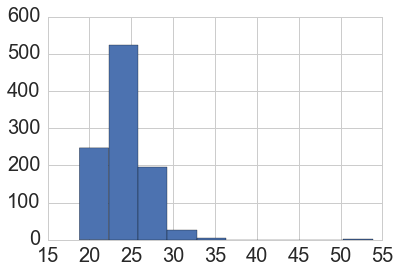

In [10]:
plt.hist(perm_dist)
plt.show()

In [11]:
def show_tfce(time, thresh):

    time_ix = list(times).index(time)
    tf = tfce[:, time_ix].squeeze()
    mask = np.where(cluster_ps[:, time_ix] <= thresh, True, False)
    
    # plot average test statistic and mark significant sensors
    image, _ = mne.viz.plot_topomap(tf, pos, mask=mask,
                                    vmin=0, vmax=30)
    
    plt.show()
    
interact(show_tfce, time=times, thresh=[.001, .005, .01, 0.05])

interactive(children=(Dropdown(description=u'time', options=(-500.0, -499.0, -498.0, -497.0, -496.0, -495.0, -494.0, -493.0, -492.0, -491.0, -490.0, -489.0, -488.0, -487.0, -486.0, -485.0, -484.0, -483.0, -482.0, -481.0, -480.0, -479.0, -478.0, -477.0, -476.0, -475.0, -474.0, -473.0, -472.0, -471.0, -470.0, -469.0, -468.0, -467.0, -466.0, -465.0, -464.0, -463.0, -462.0, -461.0, -460.0, -459.0, -458.0, -457.0, -456.0, -455.0, -454.0, -453.0, -452.0, -451.0, -450.0, -449.0, -448.0, -447.0, -446.0, -445.0, -444.0, -443.0, -442.0, -441.0, -440.0, -439.0, -438.0, -437.0, -436.0, -435.0, -434.0, -433.0, -432.0, -431.0, -430.0, -429.0, -428.0, -427.0, -426.0, -425.0, -424.0, -423.0, -422.0, -421.0, -420.0, -419.0, -418.0, -417.0, -416.0, -415.0, -414.0, -413.0, -412.0, -411.0, -410.0, -409.0, -408.0, -407.0, -406.0, -405.0, -404.0, -403.0, -402.0, -401.0, -400.0, -399.0, -398.0, -397.0, -396.0, -395.0, -394.0, -393.0, -392.0, -391.0, -390.0, -389.0, -388.0, -387.0, -386.0, -385.0, -384.0, -383.0, -382.0, -381.0, -380.0, -379.0, -378.0, -377.0, -376.0, -375.0, -374.0, -373.0, -372.0, -371.0, -370.0, -369.0, -368.0, -367.0, -366.0, -365.0, -364.0, -363.0, -362.0, -361.0, -360.0, -359.0, -358.0, -357.0, -356.0, -355.0, -354.0, -353.0, -352.0, -351.0, -350.0, -349.0, -348.0, -347.0, -346.0, -345.0, -344.0, -343.0, -342.0, -341.0, -340.0, -339.0, -338.0, -337.0, -336.0, -335.0, -334.0, -333.0, -332.0, -331.0, -330.0, -329.0, -328.0, -327.0, -326.0, -325.0, -324.0, -323.0, -322.0, -321.0, -320.0, -319.0, -318.0, -317.0, -316.0, -315.0, -314.0, -313.0, -312.0, -311.0, -310.0, -309.0, -308.0, -307.0, -306.0, -305.0, -304.0, -303.0, -302.0, -301.0, -300.0, -299.0, -298.0, -297.0, -296.0, -295.0, -294.0, -293.0, -292.0, -291.0, -290.0, -289.0, -288.0, -287.0, -286.0, -285.0, -284.0, -283.0, -282.0, -281.0, -280.0, -279.0, -278.0, -277.0, -276.0, -275.0, -274.0, -273.0, -272.0, -271.0, -270.0, -269.0, -268.0, -267.0, -266.0, -265.0, -264.0, -263.0, -262.0, -261.0, -260.0, -259.0, -258.0, -257.0, -256.0, -255.0, -254.0, -253.0, -252.0, -251.0, -250.0, -249.0, -248.0, -247.0, -246.0, -245.0, -244.0, -243.0, -242.0, -241.0, -240.0, -239.0, -238.0, -237.0, -236.0, -235.0, -234.0, -233.0, -232.0, -231.0, -230.0, -229.0, -228.0, -227.0, -226.0, -225.0, -224.0, -223.0, -222.0, -221.0, -220.0, -219.0, -218.0, -217.0, -216.0, -215.0, -214.0, -213.0, -212.0, -211.0, -210.0, -209.0, -208.0, -207.0, -206.0, -205.0, -204.0, -203.0, -202.0, -201.0, -200.0, -199.0, -198.0, -197.0, -196.0, -195.0, -194.0, -193.0, -192.0, -191.0, -190.0, -189.0, -188.0, -187.0, -186.0, -185.0, -184.0, -183.0, -182.0, -181.0, -180.0, -179.0, -178.0, -177.0, -176.0, -175.0, -174.0, -173.0, -172.0, -171.0, -170.0, -169.0, -168.0, -167.0, -166.0, -165.0, -164.0, -163.0, -162.0, -161.0, -160.0, -159.0, -158.0, -157.0, -156.0, -155.0, -154.0, -153.0, -152.0, -151.0, -150.0, -149.0, -148.0, -147.0, -146.0, -145.0, -144.0, -143.0, -142.0, -141.0, -140.0, -139.0, -138.0, -137.0, -136.0, -135.0, -134.0, -133.0, -132.0, -131.0, -130.0, -129.0, -128.0, -127.0, -126.0, -125.0, -124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0, -114.0, -113.0, -112.0, -111.0, -110.0, -109.0, -108.0, -107.0, -106.0, -105.0, -104.0, -103.0, -102.0, -101.0, -100.0, -99.0, -98.0, -97.0, -96.0, -95.0, -94.0, -93.0, -92.0, -91.0, -90.0, -89.0, -88.0, -87.0, -86.0, -85.0, -84.0, -83.0, -82.0, -81.0, -80.0, -79.0, -78.0, -77.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0, -70.0, -69.0, -68.0, -67.0, -66.0, -65.0, -64.0, -63.0, -62.0, -61.0, -60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54.0, -53.0, -52.0, -51.0, -50.0, -49.0, -48.0, -47.0, -46.0, -45.0, -44.0, -43.0, -42.0, -41.0, -40.0, -39.0, -38.0, -37.0, -36.0, -35.0, -34.0, -33.0, -32.0, -31.0, -30.0, -29.0, -28.0, -27.0, -26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.

<function __main__.show_tfce>

# TFR Power

## Make TFR Power

### Compute Raw TFR Power

In [4]:
for epo_class in ['base', 'laplacian']:
    print(epo_class)
    
    if epo_class == 'base':
        epo_root = '../data/derivatives/eeg_preprocessing/%s/epochs/%s_%s_cleaned-epo.fif'
    else:
        epo_root = '../data/derivatives/eeg_sensor/%s/lap/%s_%s_lap-epo.fif'
        
    for epo_type, epo_times in zip(epoch_types, epoch_times):
        print(epo_type)

        for subject in subjects:
            if subject == 'group':
                continue
            print(subject)

            # load subject behavior and epochs
            sub_behavior = behavior[behavior.participant_id == subject]
            f = epo_root % (subject, subject, epo_type)
            epochs = read_epochs(f, verbose=False)

            # interpolate the bad channels
            epochs.interpolate_bads(reset_bads=True)

            # drop bad trials from epochs and behavior
            sub_behavior, epochs = drop_bad_trials(subject, sub_behavior, 
                                                   epochs, layout, epo_type)

            # add event labels
            epochs = add_events(epochs, sub_behavior)

            tfrs = []
            for event in conditions:
                cond_epochs = epochs[event]

                # remove evoked response
                cond_epochs.subtract_evoked()

                # compute tfr
                power = tfr_morlet(cond_epochs, freqs=frequencies, 
                                   n_cycles=n_cycles, decim=5, 
                                   return_itc=False, average=False, n_jobs=2)

                # crop out filter buffer
                power.crop(epo_times[0], epo_times[1])
                tfrs.append(power)

            f = '../data/derivatives/eeg_sensor/%s/tfr/%s_%s_%s_raw-tfr.h5'
            write_tfrs(f % (subject, subject, epo_type, epo_class), tfrs, 
                       overwrite=True)

print('Done!')

base
stimulus
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
response
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp0

### Baseline Normalize Power

In [5]:
# cache stimulus baseline periods 
baselines = {}

for epo_class in ['base', 'laplacian']:
    for epo_type, epo_times in zip(epoch_types, epoch_times):
        print(epo_type)

        group = {'incongruent': [], 'congruent': []}
        for subject in subjects:
            if subject == 'group':
                continue
            print(subject)

            f = '../data/derivatives/eeg_sensor/%s/tfr/%s_%s_%s_raw-tfr.h5'
            tfrs = read_tfrs(f % (subject, subject, epo_type, epo_class))

            if epo_type == 'stimulus':
                baselines[subject] = {'incongruent': (-.5, -.1), 
                                      'congruent': (-.5, -.1)}

            norm_tfrs = []
            for i, c in enumerate(conditions):

                tfr, baseline = baseline_normalize(tfrs[i], 
                                                   baselines[subject][c],
                                                   func=np.median, 
                                                   method='classic')
                norm_tfrs.append(tfr)
                group[c].append(tfr)
                baselines[subject][c] = baseline


            f = '../data/derivatives/eeg_sensor/%s/tfr/%s_%s_%s_norm-tfr.h5'
            write_tfrs(f % (subject, subject, epo_type, epo_class), norm_tfrs, 
                       overwrite=True)

        group_tfrs = [grand_average(group[c]) for c in conditions]
        f = '../data/derivatives/eeg_sensor/group/tfr/group_%s_%s_norm-tfr.h5'
        write_tfrs(f % (epo_type, epo_class), group_tfrs, overwrite=True)

del baselines
del group_tfrs
print('Done!')

stimulus
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
response
sub-hc001
sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc020
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc037
sub-hc042
sub-hc044
sub-hc045
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
su

## Visualize TFR Power

### TFR Power Heatmaps

In [4]:
def plot_tfr_heatmap(subject, ch, lim, epo_class, behavior):
    
    exclusions = ['fast_rt', 'no_response', 'error', 'post_error']
    sub_behavior = behavior.loc[np.where(np.sum(behavior[exclusions], 
                                            axis=1) == 0)[0], :]
    if subject != 'group':
        sub_behavior = sub_behavior.loc[sub_behavior.participant_id == subject, :]
    sns.set(style='white', font_scale=2)
    plt.close('all')

    fig, axs = plt.subplots(2, 3, figsize=(24, 16))
    
    
    for i, epo_type in enumerate(epoch_types):
        
        f = '../data/derivatives/eeg_sensor/%s/tfr/%s_%s_%s_norm-tfr.h5'
        tfrs = read_tfrs(f % (subject, subject, epo_type, epo_class))

        powers = []
        for j, c in enumerate(conditions):
            
            power = tfrs[j]
            power.pick_channels([ch])
            ax = axs[i, j]
            rts = [sub_behavior[sub_behavior.trial_type == c].response_time]
            rt_colors = [colors[j]] 
            if epo_type == 'stimulus':
                ax = power_heatmap(power, ax, lim, rts, rt_colors)
            else:
                ax = power_heatmap(power, ax, lim)
            ax.set_title('%s %s-locked' % (c, epo_type))
                

        ax = axs[i, 2]
        power = tfrs[0] - tfrs[1] 
        power.pick_channels([ch])
        rts = [sub_behavior[sub_behavior.trial_type == c].response_time for c in conditions]
        rt_colors = [colors[0], colors[1]]
        if epo_type == 'stimulus':
            ax = power_heatmap(power, ax, lim, rts, rt_colors)
        else:
            ax = power_heatmap(power, ax, lim)

    plt.tight_layout()
    plt.subplots_adjust(top=.92)
    plt.suptitle('%s %s TFR Heatmaps (Color Limit: +- %s)' % (subject, ch, lim), 
                 fontsize=24)
    plt.show()

interact(plot_tfr_heatmap, subject=subjects, ch=CH_NAMES, 
         lim=(.5, 4, .5), epo_class=['base', 'laplacian'], 
         behavior=fixed(behavior));

interactive(children=(Dropdown(description=u'subject', options=('group', 'sub-hc001', 'sub-hc002', 'sub-hc003', 'sub-hc004', 'sub-hc005', 'sub-hc006', 'sub-hc007', 'sub-hc008', 'sub-hc009', 'sub-hc010', 'sub-hc011', 'sub-hc012', 'sub-hc014', 'sub-hc015', 'sub-hc016', 'sub-hc017', 'sub-hc019', 'sub-hc020', 'sub-hc021', 'sub-hc022', 'sub-hc023', 'sub-hc024', 'sub-hc025', 'sub-hc026', 'sub-hc028', 'sub-hc029', 'sub-hc030', 'sub-hc031', 'sub-hc032', 'sub-hc033', 'sub-hc034', 'sub-hc035', 'sub-hc036', 'sub-hc037', 'sub-hc042', 'sub-hc044', 'sub-hc045', 'sub-pp001', 'sub-pp002', 'sub-pp003', 'sub-pp004', 'sub-pp005', 'sub-pp006', 'sub-pp007', 'sub-pp008', 'sub-pp009', 'sub-pp010', 'sub-pp011', 'sub-pp012', 'sub-pp013', 'sub-pp014', 'sub-pp015', 'sub-pp016'), value='group'), Dropdown(description=u'ch', options=('Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T9', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'P0z', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz'), value='Fp1'), FloatSlider(value=2.0, description=u'lim', max=4.0, min=0.5, step=0.5), Dropdown(description=u'epo_class', options=('base', 'laplacian'), value='base'), Output()), _dom_classes=('widget-interact',))

### TFR Power Topomaps

In [5]:
def plot_topomap(subject, epo_type, epo_class, time, fmin, fmax, col_limit):
    plt.close('all')
    f = '../data/derivatives/eeg_sensor/%s/tfr/%s_%s_%s_norm-tfr.h5'
    tfrs = read_tfrs(f % (subject, subject, epo_type, epo_class))

    f, axs = plt.subplots(1, 3, figsize=(24, 6)) 
    
    for i, tfr in enumerate(tfrs):
        tfr.plot_topomap(tmin=time, tmax=time + .005,
                         fmin=fmin, fmax=fmax, axes=axs[i], colorbar=True, 
                         show=False, vmin=-col_limit, vmax=col_limit)
        axs[i].set_xlabel(conditions[i])
        
    diff = tfrs[0] - tfrs[1]
    diff.plot_topomap(tmin=time, tmax=time + .005,
                      fmin=fmin, fmax=fmax, axes=axs[2], colorbar=True, 
                      show=False, vmin=-col_limit, vmax=col_limit)
    axs[2].set_xlabel('i-c')
    plt.suptitle('%.2f s' % time)
    
    plt.show()

interact(plot_topomap, subject=['group'] + subjects, 
         epo_type=['response', 'stimulus'],
         epo_class=['base', 'laplacian'],
         time=np.arange(-1, 1.75, .01), 
         fmin=frequencies, fmax=frequencies,
         col_limit=np.arange(.5, 5, .5));


interactive(children=(Dropdown(description=u'subject', options=('group', 'group', 'sub-hc001', 'sub-hc002', 'sub-hc003', 'sub-hc004', 'sub-hc005', 'sub-hc006', 'sub-hc007', 'sub-hc008', 'sub-hc009', 'sub-hc010', 'sub-hc011', 'sub-hc012', 'sub-hc014', 'sub-hc015', 'sub-hc016', 'sub-hc017', 'sub-hc019', 'sub-hc020', 'sub-hc021', 'sub-hc022', 'sub-hc023', 'sub-hc024', 'sub-hc025', 'sub-hc026', 'sub-hc028', 'sub-hc029', 'sub-hc030', 'sub-hc031', 'sub-hc032', 'sub-hc033', 'sub-hc034', 'sub-hc035', 'sub-hc036', 'sub-hc037', 'sub-hc042', 'sub-hc044', 'sub-hc045', 'sub-pp001', 'sub-pp002', 'sub-pp003', 'sub-pp004', 'sub-pp005', 'sub-pp006', 'sub-pp007', 'sub-pp008', 'sub-pp009', 'sub-pp010', 'sub-pp011', 'sub-pp012', 'sub-pp013', 'sub-pp014', 'sub-pp015', 'sub-pp016'), value='group'), Dropdown(description=u'epo_type', options=('response', 'stimulus'), value='response'), Dropdown(description=u'epo_class', options=('base', 'laplacian'), value='base'), Dropdown(description=u'time', options=(-1.0, -0.98999999999999999, -0.97999999999999998, -0.96999999999999997, -0.95999999999999996, -0.94999999999999996, -0.93999999999999995, -0.92999999999999994, -0.91999999999999993, -0.90999999999999992, -0.89999999999999991, -0.8899999999999999, -0.87999999999999989, -0.86999999999999988, -0.85999999999999988, -0.84999999999999987, -0.83999999999999986, -0.82999999999999985, -0.81999999999999984, -0.80999999999999983, -0.79999999999999982, -0.78999999999999981, -0.7799999999999998, -0.7699999999999998, -0.75999999999999979, -0.74999999999999978, -0.73999999999999977, -0.72999999999999976, -0.71999999999999975, -0.70999999999999974, -0.69999999999999973, -0.68999999999999972, -0.67999999999999972, -0.66999999999999971, -0.6599999999999997, -0.64999999999999969, -0.63999999999999968, -0.62999999999999967, -0.61999999999999966, -0.60999999999999965, -0.59999999999999964, -0.58999999999999964, -0.57999999999999963, -0.56999999999999962, -0.55999999999999961, -0.5499999999999996, -0.53999999999999959, -0.52999999999999958, -0.51999999999999957, -0.50999999999999956, -0.49999999999999956, -0.48999999999999955, -0.47999999999999954, -0.46999999999999953, -0.45999999999999952, -0.44999999999999951, -0.4399999999999995, -0.42999999999999949, -0.41999999999999948, -0.40999999999999948, -0.39999999999999947, -0.38999999999999946, -0.37999999999999945, -0.36999999999999944, -0.35999999999999943, -0.34999999999999942, -0.33999999999999941, -0.3299999999999994, -0.3199999999999994, -0.30999999999999939, -0.29999999999999938, -0.28999999999999937, -0.27999999999999936, -0.26999999999999935, -0.25999999999999934, -0.24999999999999933, -0.23999999999999932, -0.22999999999999932, -0.21999999999999931, -0.2099999999999993, -0.19999999999999929, -0.18999999999999928, -0.17999999999999927, -0.16999999999999926, -0.15999999999999925, -0.14999999999999925, -0.13999999999999924, -0.12999999999999923, -0.11999999999999922, -0.10999999999999921, -0.099999999999999201, -0.089999999999999192, -0.079999999999999183, -0.069999999999999174, -0.059999999999999165, -0.049999999999999156, -0.039999999999999147, -0.029999999999999138, -0.01999999999999913, -0.0099999999999991207, 8.8817841970012523e-16, 0.010000000000000897, 0.020000000000000906, 0.030000000000000915, 0.040000000000000924, 0.050000000000000933, 0.060000000000000941, 0.07000000000000095, 0.080000000000000959, 0.090000000000000968, 0.10000000000000098, 0.11000000000000099, 0.12000000000000099, 0.130000000000001, 0.14000000000000101, 0.15000000000000102, 0.16000000000000103, 0.17000000000000104, 0.18000000000000105, 0.19000000000000106, 0.20000000000000107, 0.21000000000000107, 0.22000000000000108, 0.23000000000000109, 0.2400000000000011, 0.25000000000000111, 0.26000000000000112, 0.27000000000000113, 0.28000000000000114, 0.29000000000000115, 0.30000000000000115, 0.31000000000000116, 0.32000000000000117, 0.33000000000000118, 0.34000000000000119, 0.3500000000000012, 0.36000000000000121, 0.37000000000000122, 0.3800000000000